# Generating Partitions of Graph Vertices into Connected Components

In this code, we aim to generate all possible partitions of the vertices in a graph into **connected components**. Each partition represents a different way the vertices could be grouped into distinct connected components, starting from a fully disconnected graph where each vertex is its own component.

## Canonical Set Partition Generation

This code generates **canonical partitions** of a set of elements (e.g., graph vertices), ensuring that the partitions are consistently ordered for predictability and standardization.

Key implementation steps:

1. **Partition Generation**:
   - The function `generate_canonical_partitions(elements)` generates all possible partitions of the input set using SymPy’s `multiset_partitions`. Each partition is a way to group the elements into distinct subsets.

2. **Canonical Representation**:
   - Each partition is converted into a **tuple of tuples**, ensuring immutability and making it suitable for use as dictionary keys. The elements in each subset, as well as the subsets themselves, are sorted to maintain a canonical (consistent) order. This ensures that the partitions are presented in a standard form.

3. **Mapping Partitions to Indices**:
   - The function also constructs a dictionary `partition_to_index` that maps each canonical partition to its respective index in the sorted list of partitions. This mapping allows for efficient referencing of partitions by their index.


In [1]:
from pprint import pprint
from sympy.utilities.iterables import multiset_partitions


def generate_canonical_partitions(elements):
    """
    Generate canonical partitions for a given set of elements.
    A canonical partition is one where both the elements of each subset
    and the subsets themselves are sorted in a consistent way. Each partition
    is returned as a tuple of tuples.

    Parameters:
    elements (list): A list of elements to partition.

    Returns:
    list: A list of canonical partitions, where each partition is a tuple of tuples.
    dict: A dictionary mapping each partition (as a tuple of tuples) to its index.
    """
    partitions = list(multiset_partitions(elements))
    
    # Sort the elements in each subset and the subsets themselves
    canonical_partitions = [tuple(sorted(tuple(sorted(subset)) for subset in partition)) for partition in partitions]
    canonical_partitions.sort()
    
    # Create the mapping from partition (tuple of tuples) to its index
    partition_to_index = {partition: idx for idx, partition in enumerate(canonical_partitions)}
    
    return canonical_partitions, partition_to_index

# Example usage
elements = list(range(1, 4))  # Set of elements {1, 2, 3}
canonical_partitions, partition_to_index = generate_canonical_partitions(elements)

# Pretty print the results
print("Canonical Partitions:")
pprint(canonical_partitions, width=60)  # Pretty print with line width control

print("\nPartition to Index Mapping:")
pprint(partition_to_index, width=60)


Canonical Partitions:
[((1,), (2,), (3,)),
 ((1,), (2, 3)),
 ((1, 2), (3,)),
 ((1, 2, 3),),
 ((1, 3), (2,))]

Partition to Index Mapping:
{((1,), (2,), (3,)): 0,
 ((1,), (2, 3)): 1,
 ((1, 2), (3,)): 2,
 ((1, 2, 3),): 3,
 ((1, 3), (2,)): 4}


## Generating Component Partitions and Edge-Based Transformations

In this code, we aim to generate all possible **component partitions** of a graph vertices, which are enumerated from `1` to `n_vertices`. 

Next, we define a **transforms** dictionary that represents how the partition of components changes when an edge is added between two vertices `(a, b)`:
- If the vertices `a` and `b` are already in the same connected component, no transformation is needed.
- If `a` and `b` belong to different components, the code merges the two components and updates the partition accordingly.

The mapping `transforms[(a, b)]` stores the updated partitions for each pair of vertices `(a, b)` after adding the edge. Since adding an edge between `a` and `b` is symmetric, the transformation is also stored for `(b, a)`. 

In [2]:
from collections import defaultdict
import itertools

# Number of vertices in the graph
n_vertices = 10

# Generate canonical partitions and the partition-to-index mapping
vertices = list(range(1, n_vertices + 1))
partitions, partition_map = generate_canonical_partitions(vertices)

# Dictionary to store the transformations for each vertex pair
transforms = defaultdict(list)

# Iterate over all combinations of vertex pairs
for a, b in itertools.combinations(vertices, 2):
    transform = [0] * len(partitions)
    
    # Iterate over all partitions
    for part_id, part in enumerate(partitions):
        # Find the subsets that contain vertices a and b
        a_id = next(idx for idx, subset in enumerate(part) if a in subset)
        b_id = next(idx for idx, subset in enumerate(part) if b in subset)
        
        if a_id == b_id:
            # No transformation needed if a and b are already in the same subset
            transform[part_id] = part_id
            continue
        
        # Create a new partition by merging the subsets that contain a and b
        new_part = [part[k] for k in range(len(part)) if k not in [a_id, b_id]]
        merged_subset = tuple(sorted(set(part[a_id]).union(set(part[b_id]))))
        new_part.append(merged_subset)
        new_part.sort()

        # Get the index of the new partition
        new_part_id = partition_map[tuple(new_part)]
        transform[part_id] = new_part_id
    
    # Store the transformation for both (a, b) and (b, a) since the operation is symmetric
    transforms[(a, b)] = transform
    transforms[(b, a)] = transform


## Description of the Hyperedge Structure

In this setup, we consider a **hyperedge** that connects three vertices $a$, $b$, and $c$ in the WZ model. Vertex $a$ is the selected or central vertex.

### Hyperedge Behavior:
- **With probability $p_{a|b|c}$**: No edges are added between $a$, $b$, or $c$.
- **With probability $p_{a|bc}$**: An edge is added between $b$ and $c$.
- **With probability $p_{ab|c}$**: An edge is added between $a$ and $b$.
- **With probability $p_{ac|b}$**: An edge is added between $a$ and $c$.
- **With probability $p_{abc}$**: The edges between $a$ and $b$ and between $a$ and $c$, are added.

### Illustration of the Hyperedge:

The illustration below visualizes this structure. Vertex $a$ is placed at the top of an equilateral triangle, while vertices $b$ and $c$ are at the base. The features of the hyperedge are represented as follows:

- The **selected vertex** $a$ is marked in **gray** to indicate its central role in the hyperedge.
- The **blue edges** represent the connections between the selected vertex $a$ and the non-selected vertices $b$ and $c$.
- The **red edge** represents the connection between the non-selected vertices $b$ and $c$.
- The interior of the triangle is filled with a **yellow** color to represent the situation where all edges are added with probability $p_{abc}$.


<div>
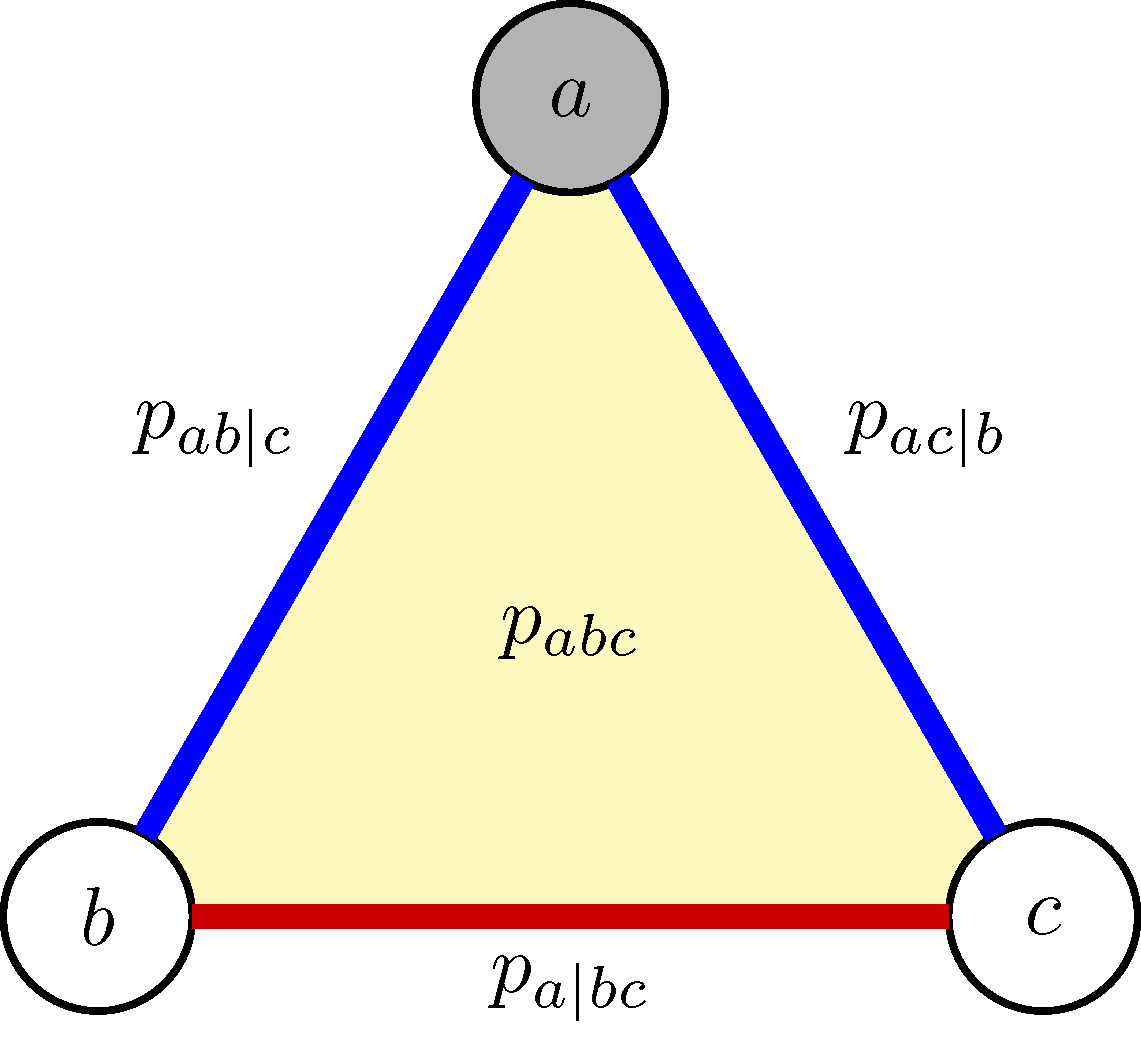
</div>

In [3]:
from sympy import symbols, Poly
import numpy as np

# Define symbolic variables for the probabilities
hyperedge_probs = {
    'a|b|c': symbols('p_{a|b|c}'), 
    'a|bc': symbols('p_{a|bc}'),
    'ac|b': symbols('p_{ac|b}'),
    'ab|c': symbols('p_{ab|c}'),
    'abc': symbols('p_{abc}'),
}
gens = list(hyperedge_probs.values())

## Applying Hyperedge Additions to Partition Probabilities

The `add_hyperedge` function models how adding a $3$-edge in the WZ model between three vertices `(a, b, c)` affects the probability distribution over all possible partitions of the graph's vertices. The function applies hyperedge addition transformations to the partition probabilities for the triangle of vertices and updates the connected components based on these additions.

Key steps in the implementation:

1. **Input Parameters**:
   - `probs`: A list representing the current probability distribution over partitions.
   - `vertices`: A tuple containing the three vertices `(a, b, c)` involved in the transformation.
   - `edge_probs`: A dictionary of formal variables representing the probabilities of adding a $3$-edge of a particular type in WZ model. The keys correspond to the partitions of the set $\{a, b, c\}$.
   - `transforms`: A dictionary that defines how the partitions are transformed when specific edges are added.

2. **Updating Partition Probabilities**:
   - The function initializes a new list `new_probs`, which starts as the current `probs` scaled by the probability of no edges being added (`'a|b|c'`).
   - It then loops over all partition indices and applies one of the transformations for each edge addition case:
     - With probability `'a|bc'` it adds the edge between `b` and `c` and updates the corresponding partition.
     - With probability `'b|ac'` it adds the edge between `a` and `c` and updates the partition.
     - With probability `'c|ab'` it adds the edge between `a` and `b` and updates the partition.
     - Finally, with probability `'abc'` it adds both edges `a-b` and `a-c` and updates the partition accordingly.

The function returns the new probability distribution `new_probs`.


In [4]:
def add_hyperedge(probs, vertices, edge_probs, transforms):
    """
    Applies edge addition transformations to the partition probabilities for a triangle of vertices (a, b, c).

    Parameters:
    probs (list): The current probability distribution over partitions.
    vertices (tuple): The three vertices (a, b, c) involved in the transformation.
    edge_probs (dict): A dictionary of probabilities for different edge additions. Keys:
        - 'a|b|c': probability of no edges being added.
        - 'a|bc': probability of adding edge between b and c.
        - 'ac|b': probability of adding edge between a and c.
        - 'ab|c': probability of adding edge between a and b.
        - 'abc': probability of adding edges a-b and a-c.
    transforms (dict): The transformation dictionary that maps every edge to how partitions change when the edge is added.

    Returns:
    new_probs (list): Updated probability distribution over partitions.
    """
    a, b, c = vertices
    
    # Create a new list to store the updated probabilities
    new_probs = probs * edge_probs['a|b|c']  # Initialize with scaled probs for 'a|b|c' (no edges added)
    
    # Loop over each partition index
    for k in range(len(probs)):
        # a|bc -- adding edge between b and c
        new_probs[transforms[(b, c)][k]] += probs[k] * edge_probs['a|bc']
        
        # ac|b -- adding edge between a and c
        new_probs[transforms[(a, c)][k]] += probs[k] * edge_probs['ac|b']
        
        # ab|c -- adding edge between a and b
        new_probs[transforms[(a, b)][k]] += probs[k] * edge_probs['ab|c']
        
        # abc -- adding both edges a-b and a-c
        idx = transforms[(a, b)][k]
        idx = transforms[(a, c)][idx]
        new_probs[idx] += probs[k] * edge_probs['abc']
    
    return new_probs


# Graph with 10 Vertices and Hyperedges

We now consider Hollom's $3$-regular hypergraph with **10 vertices**, labeled from $u_1$ to $u_{10}$. In this graph, we add **6 i.i.d. hyperedges**, as illustrated in the diagram below.

<img src="images/graph.png" width="350" />

We run a WZ percolation on this hypergraph. Specifically, the hyperedges act between the following sets of vertices (the first vertex of each hyperedge is the selected one):
1. $(u_2, u_1, u_3)$
2. $(u_2, u_4, u_5)$
3. $(u_9, u_3, u_6)$
4. $(u_7, u_4, u_8)$
5. $(u_7, u_5, u_6)$
6. $(u_9, u_8, u_{10})$

In the graph, the **transversal vertices** ($u_2$, $u_7$, and $u_9$) are marked in **gray**, and the edges between these vertices and other vertices are represented in **blue**. The edge between two non-selected vertices is shown in **red**. 

We aim to find the probability distribution on the connected components of the graph.

In [5]:
# Initialize probs as a zeros array of polynomials with one non-zero initial element
probs = np.zeros(len(partitions), dtype=object)
probs[0] = Poly(1, gens)  # Start with the first partition having probability 1

# Apply add_hyperedge (previously add_triangle) for specific vertex triples
probs = add_hyperedge(probs, [2, 1, 3], hyperedge_probs, transforms)
probs = add_hyperedge(probs, [2, 4, 5], hyperedge_probs, transforms)
probs = add_hyperedge(probs, [7, 5, 6], hyperedge_probs, transforms)
probs = add_hyperedge(probs, [7, 4, 8], hyperedge_probs, transforms)
probs = add_hyperedge(probs, [9, 3, 6], hyperedge_probs, transforms)
probs = add_hyperedge(probs, [9, 8, 10], hyperedge_probs, transforms)


## Restricting to Key Vertices for the Bunkbed Problem

In the context of the **bunkbed conjecture**, our objective does not require knowledge of the probability distribution over all possible partitions of the entire graph's vertices. Instead, the problem can be simplified by focusing only on a subset of **key vertices** -- specifically, the source vertex $u_1$, the target vertex $u_{10}$, and the transversal vertices $u_2$, $u_7$, and $u_9$. 

Rather than working with the full partitions of the graph, which include all 10 vertices, we are primarily interested in the probability distribution over the connected components of this smaller subset of **5 key vertices**. 

#### Approach:
1. **Mapping Full Partitions to Key Vertices**:
   - To achieve this reduction, we first define a **restriction mapping** that projects each full partition of the 10 vertices onto a partition of the key vertices. This mapping essentially discards the irrelevant vertices and focuses solely on how the source, target, and transversal vertices are connected to one another in the partition.

2. **Computing the Probability Distribution**:
   - Once the restriction mapping is defined, we can apply it to the probabilities associated with the full partitions. By doing so, we transform the probability distribution over the full set of partitions into a probability distribution over the partitions of the key vertices which we call **restricted partitions**.


In [6]:
# Define the source, target, and transversal vertices
source_vertex = 1
target_vertex = 10
transversal_vertices = [2, 7, 9]

# Define the subset of vertices we are interested in (source, target, and transversals)
restricted_vertices = [source_vertex] + transversal_vertices + [target_vertex]

# Generate canonical partitions and the partition-to-index mapping for the restricted vertices
restricted_partitions, restricted_partition_map = generate_canonical_partitions(restricted_vertices)

# Initialize an array to store the mapping from the full partition space to the restricted partition space
projection_map = np.zeros(len(partitions), dtype=int)

# Map each full partition to the corresponding restricted partition
for part_id, full_part in enumerate(partitions):
    # Restrict the full partition to the set of restricted vertices
    restricted_part = [sorted(set(block).intersection(restricted_vertices)) for block in full_part]
    restricted_part = [block for block in restricted_part if block]  # Remove empty blocks
    restricted_part.sort()

    # Get the corresponding index for the restricted partition
    restricted_part_id = restricted_partition_map[tuple(map(tuple, restricted_part))]
    projection_map[part_id] = restricted_part_id


In [7]:
# Initialize an array for the probability distribution over restricted partitions
restricted_probs = np.zeros(len(restricted_partitions), dtype=object)

for full_part_id, full_part in enumerate(partitions):
    restricted_part_id = projection_map[full_part_id]    
    restricted_probs[restricted_part_id] += probs[full_part_id]


# Objective in the Bunkbed Conjecture: Computing the Difference of Probabilities

In this part of the code, we compute the **difference of two probabilities** that are central to the **bunkbed conjecture for WZ-percolation**. The conjecture involves analyzing the bunkbed graph that contains two independent copies of a hypergraph with transversal vertices connected to their copies via posts.

## Setup:
1. **Two Independent Copies of the Graph**:
   - We create two independent copies of the original graph:
     - The vertices of the **first copy** are labeled as $(u, 1)$.
     - The vertices of the **second copy** are labeled as $(u, 2)$.
   - These copies are identical except that corresponding **transversal vertices** in both copies are connected with probability 1. In this example, the transversal vertices are $u_2$, $u_7$, and $u_9$.

2. **Two Key Probabilities**:
   We are interested in computing the following two probabilities:
   - The probability that the source vertex in the first copy $(u_1, 1)$ is connected to the target vertex in the same copy $(u_{10}, 1)$.
   - The probability that the source vertex in the first copy $(u_1, 1)$ is connected to the target vertex in the second copy $(u_{10}, 2)$.

3. **Objective**:
   The **difference** between these two probabilities is the objective of the bunkbed conjecture. This code computes this difference by iterating over all possible partitions of the key vertices and evaluating how the source and target vertices are connected in the two graph copies.

## How the Code Works:
- **Block Combination**:
  - For each partition of the graph, represented by $q_1$ and $q_2$ for the two copies, we label the vertices in each copy as $(u, 1)$ and $(u, 2)$.
  - The code combines the partitions from both copies into **blocks** and iterates over each of the **transversal vertices** $(u_2, u_7, u_9)$. The blocks containing these transversal vertices are **merged** to ensure that corresponding vertices in the two copies are connected.

- **Connectivity Check**:
  - After processing the transversal vertices, the code checks:
    - Whether the source vertex $(u_1, 1)$ and target vertex $(u_{10}, 1)$ are in the **same connected component** in the first copy.
    - Whether the source vertex $(u_1, 1)$ and target vertex $(u_{10}, 2)$ are in the **same connected component** across both copies.

- **Updating the Objective**:
  - If the source and target are connected in the **first copy** ($(u_1, 1)$ and $(u_{10}, 1)$ are in the same block), the product of their probabilities from the partition probability distribution is **added** to the objective.
  - If the source and target are connected **across both copies** ($(u_1, 1)$ and $(u_{10}, 2)$ are in the same block), the product of their probabilities is **subtracted** from the objective.

This iterative process over all possible partitions and combinations of the two graph copies yields the final objective value in `bunkbed_obj`. The conjecture claims that `bunkbed_obj` is nonnegative for any hypergraph and probabilities that can be emulated in edge percolation.


In [8]:
bunkbed_obj = Poly(0, gens) # Initialize the polynomial for the final objective

# Iterate over all combinations of partitions for the two independent graph copies
for part_1_id, part_1 in enumerate(restricted_partitions):
    for part_2_id, part_2 in enumerate(restricted_partitions):
        # Create blocks by combining the partitions from the two copies
        # First copy vertices are labeled as (u, 1) and second copy vertices as (u, 2)
        combined_blocks = [list(map(lambda v: (v, 1), block)) for block in part_1] + \
                          [list(map(lambda v: (v, 2), block)) for block in part_2]

        # Process the transversal vertices, ensuring they are connected between the two copies
        for vertex in transversal_vertices:
            block_1_idx = next(idx for idx, block in enumerate(combined_blocks) if (vertex, 1) in block)
            block_2_idx = next(idx for idx, block in enumerate(combined_blocks) if (vertex, 2) in block)

            # Merge the blocks containing the transversal vertex in both copies
            new_combined_blocks = [
                combined_blocks[i] for i in range(len(combined_blocks))
                if i not in [block_1_idx, block_2_idx]
            ]
            merged_block = sorted(set(combined_blocks[block_1_idx]).union(combined_blocks[block_2_idx]))
            new_combined_blocks.append(merged_block)
            combined_blocks = new_combined_blocks

        # Check if source and target are connected in the first copy
        if any((source_vertex, 1) in block and (target_vertex, 1) in block for block in combined_blocks):
            bunkbed_obj += restricted_probs[part_1_id] * restricted_probs[part_2_id]
        
        # Check if source and target are connected across both copies
        if any((source_vertex, 1) in block and (target_vertex, 2) in block for block in combined_blocks):
            bunkbed_obj -= restricted_probs[part_1_id] * restricted_probs[part_2_id]


## Analysis of the Polynomial: Coefficient Extraction and Factorization

In this part of the analysis, we turn our attention to the polynomial that arises from the bunkbed conjecture and its associated probability terms. Our focus is on isolating and understanding the structure of the terms involving powers of $p_{a|bc}^k$. Specifically, we will extract the coefficients of $p_{a|bc}^k$ as polynomials in $p_{abc}$ and the remaining variables, and subsequently factorize these expressions to reveal any underlying structure.

Given the expanded form of the polynomial

$$
BB(p_{abc}, p_{a|bc}, p_{ab|c}, p_{ac|b}, p_{a|b|c}),
$$

we isolate the terms containing powers of $p_{a|bc}^k$. For a fixed $k$, the coefficient of $p_{a|bc}^k$ is extracted and written as a polynomial in the remaining variables $p_{abc}, p_{ab|c}, p_{ac|b}, p_{a|b|c}$. The resulting expression is denoted as:

$$
\text{Coeff}(p_{a|bc}^k) = C_k(p_{abc}, p_{ab|c}, p_{ac|b}, p_{a|b|c}),
$$

where $C_k$ represents the polynomial that forms the coefficient of $p_{a|bc}^k$. After isolating $C_k$, we proceed to factorize this polynomial.


In [9]:
from sympy import collect, factor, symbols, latex
from IPython.display import display, Math

# Collect terms in the polynomial expression based on powers of p_{a|bc}
collected_bunkbed_on_p2 = collect(bunkbed_obj.as_expr(), hyperedge_probs['a|bc'])

# Iterate over the range of powers for p_{a|bc}, from 0 to 6
for k in range(6):
    # Extract the coefficient of the term (p_{a|bc})^k from the collected expression
    coeff_k = collected_bunkbed_on_p2.coeff(hyperedge_probs['a|bc'], k)
    
    # Factorize the extracted coefficient for simplicity and pattern recognition
    factored_coeff_k = factor(coeff_k)
    
    # Prepare a LaTeX string to display the factored coefficient nicely
    latex_expr = f"\\text{{Coefficient of }} p_{{a|bc}}^{{{k}}}: " + latex(factored_coeff_k)
    
    # Display the LaTeX representation of the factored coefficient in the notebook
    display(Math(latex_expr))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Divisibility and Estimation of Coefficients

We observe that the coefficient of $p_{a|bc}^k$, denoted as $\text{Coeff}(p_{a|bc}^k)$, is divisible by the factor $(p_{abc} \cdot p_{a|b|c} - p_{ab|c} \cdot p_{ac|b})^{6 - k}$ for $0 \leq k \leq 6$. Specifically, the coefficient of $p_{a|bc}^0$ is given by:

$$
\text{Coeff}(p_{a|bc}^0) = - \left( p_{abc} \cdot p_{a|b|c} - p_{ab|c} \cdot p_{ac|b} \right)^6.
$$

For $1 \leq k \leq 6$, we can estimate the coefficient $\text{Coeff}(p_{a|bc}^k)$ from above as:

$$
\text{Coeff}(p_{a|bc}^k) \leq \left( p_{abc} \cdot p_{a|b|c} - p_{ab|c} \cdot p_{ac|b} \right)^{6 - k} \cdot s_k,
$$

where $s_k$ is some constant.

For $k \geq 7$, the coefficient $\text{Coeff}(p_{a|bc}^k)$ is estimated from above as a constant $s_k$.

Thus, we can estimate the entire polynomial $BB(p_{abc}, p_{a|bc}, p_{ab|c}, p_{ac|b}, p_{a|b|c})$ as:

$$
BB(p_{abc}, p_{a|bc}, p_{ab|c}, p_{ac|b}, p_{a|b|c}) \leq - \left( p_{abc} \cdot p_{a|b|c} - p_{ab|c} \cdot p_{ac|b} \right)^6 + \sum_{k=1}^6 s_k \cdot p_{a|bc}^k \cdot \left( p_{abc} \cdot p_{a|b|c} - p_{ab|c} \cdot p_{ac|b} \right)^{6 - k} + \sum_{k=7}^{12} s_k \cdot p_{a|bc}^k.
$$

Given that $p_{a|bc} \leq 1$, we can bound last terms of this polynomial from above:
$$
\sum_{k=7}^{12} s_k \cdot p_{a|bc}^k \leq p_{a|bc}^6\sum_{k = 7}^{12}|s_k|.
$$

Denoting $c_k = s_k$ for $1 \le k \le 5$ and $c_6 = s_6 + \sum_{k = 7}^{12}|s_k|$, we finally get an estimate
$$
BB(p_{abc}, p_{a|bc}, p_{ab|c}, p_{ac|b}, p_{a|b|c}) \leq - \left( p_{abc} \cdot p_{a|b|c} - p_{ab|c} \cdot p_{ac|b} \right)^6 + \sum_{k=1}^6 c_k \cdot p_{a|bc}^k \cdot \left( p_{abc} \cdot p_{a|b|c} - p_{ab|c} \cdot p_{ac|b} \right)^{6 - k}.
$$

Denoting 

$$
t = \frac{p_{abc} \cdot p_{a|b|c} - p_{ab|c} \cdot p_{ac|b}}{p_{a|bc}},
$$

we can further estimate it as:

$$
BB(p_{abc}, p_{a|bc}, p_{ab|c}, p_{ac|b}, p_{a|b|c}) \leq p_{a|bc}^6 \cdot \left( - t^6 + \sum_{k = 0}^5 c_{6-k} t^k \right),
$$

where $c_k$ are absolute constants.


## Sufficient Condition For Counterexample

We observe that the polynomial

$$
-t^6 + \sum_{k=0}^5 c_{6-k} t^k
$$

is negative for $t > |c_1| + |c_2| + \cdots + |c_6|$. This implies that for sufficiently large $t$, the expression will always be negative. Thus, it is sufficient to show that for any constant $C$, we can construct a gadget graph such that:

$$
p_{abc} \cdot p_{a|b|c} - p_{ab|c} \cdot p_{ac|b} > C \cdot p_{a|bc}.
$$

This construction will guarantee that $t = \frac{p_{abc} \cdot p_{a|b|c} - p_{ab|c} \cdot p_{ac|b}}{p_{a|bc}}$ exceeds the threshold $|c_1| + |c_2| + \cdots + |c_6|$.


# Description of the Gadget Graph Structure

We consider a graph $G_n$ with a central vertex $a$ and $n$ peripheral vertices $u_1, u_2, \dots, u_n$. Vertex $a$ is connected to each peripheral vertex $u_i$ by an edge that is open with probability $1 - p$, and each peripheral vertex $u_i$ is connected to its neighbor $u_{i+1}$ by an edge that is open with probability $p$.

We will use this graph to model the hyperedge in the bunkbed conjecture, where vertex $b = u_1$ and vertex $c = u_n$.



![map](attachement:images/gadget.jpg)

## Theorem

In a graph $G_n$:

\begin{align*}
p_{ab} &= p_{ac} = P(a \leftrightarrow u_1) = \frac{1 - p^{2n}}{1 + p} \\
p_{abc} &= P(a \leftrightarrow u_1 \land a \leftrightarrow u_n) = \frac{1 - p^{2n} + n(1 - p^2)p^{2n-1}}{(1 + p)^2} \\
p_{a|bc} &= p^{2n - 1}
\end{align*}

and therefore,

\begin{align*}
p_{abc}p_{a|b|c} - p_{ab|c}p_{ac|b} &> \left(n\frac{1 - p}{1 + p} - 1\right)p_{a|bc}.
\end{align*}


## Smallest counterexample

We can now use the derived formulas for $p_{abc}$, $p_{ab}$, $p_{ac}$, and $p_{a|bc}$ to get better estimates on the number of vertices in the optimal graph. By substituting these probability expressions into the overall polynomial model for the bunkbed conjecture, we aim to find the number of peripheral vertices $n$ that provides a counterexample to the bunkbed conjecture. It turns out that $n = 5$ suffices.


In [10]:
from sympy import expand  # We will use expand to simplify the result


n = 5  # Number of peripheral vertices in the graph
p = symbols('p')  # Symbolic representation of the edge probability p

# Define the probability expressions for the various events in terms of p and n
probs = {
    # p_abc: The probability that a is connected to both b (u_1) and c (u_n) via open edges
    'abc': Poly((1 - p**(2*n) + n * (1 - p)*(1 + p) * p**(2*n - 1)), [p]) // (1 + p)**2,
    
    # p_ab and p_ac: The probabilities that a is connected to b or c respectively
    'ab': Poly(1 - p**(2*n), [p]) // (1 + p),
    'ac': Poly(1 - p**(2*n), [p]) // (1 + p),
    
    # p_a|bc: The probability that a is connected to b but not directly to c
    'a|bc': Poly(p**(2*n - 1), [p])
}

# Substitute these probability expressions into the bunkbed conjecture's objective function (bunkbed_obj)
substituted_bunkbed_obj = bunkbed_obj.subs({
    hyperedge_probs['abc']: probs['abc'].as_expr(),  # Substituting p_abc
    hyperedge_probs['ab|c']: (probs['ab'] - probs['abc']).as_expr(),  # p_ab|c = p_ab - p_abc
    hyperedge_probs['ac|b']: (probs['ac'] - probs['abc']).as_expr(),  # p_ac|b = p_ac - p_abc
    hyperedge_probs['a|bc']: (probs['a|bc']).as_expr(),  # Substituting p_a|bc
    # p_a|b|c: The probability that a is connected neither to b nor c
    hyperedge_probs['a|b|c']: (1 - probs['ab'] - probs['ac'] - probs['a|bc'] + probs['abc']).as_expr()
})

# Expand and simplify the resulting polynomial expression
expand(substituted_bunkbed_obj.as_expr())


-2241*p**108 + 19166*p**107 - 84725*p**106 + 262714*p**105 - 649573*p**104 + 1372150*p**103 - 2581261*p**102 + 4442028*p**101 - 7122167*p**100 + 10778486*p**99 - 15538216*p**98 + 21474692*p**97 - 28590303*p**96 + 36822496*p**95 - 46076471*p**94 + 56280040*p**93 - 67454251*p**92 + 79791382*p**91 - 93727626*p**90 + 109993960*p**89 - 129631701*p**88 + 153961428*p**87 - 184490415*p**86 + 222749224*p**85 - 270064340*p**84 + 327287334*p**83 - 394512058*p**82 + 470822126*p**81 - 554117065*p**80 + 641064310*p**79 - 727210644*p**78 + 807262504*p**77 - 875523190*p**76 + 926456304*p**75 - 955319287*p**74 + 958780088*p**73 - 935408030*p**72 + 885943726*p**71 - 813303442*p**70 + 722320268*p**69 - 619248441*p**68 + 511079838*p**67 - 404751334*p**66 + 306350834*p**65 - 220461924*p**64 + 149794452*p**63 - 95165863*p**62 + 55762370*p**61 - 29553471*p**60 + 13772056*p**59 - 5409516*p**58 + 1676380*p**57 - 366060*p**56 + 44444*p**55 - 1184*p**54

For $n = 5$, the term $-1184 p^{54}$ dominates all other terms as $p \to 0$. This means that for sufficiently small values of $p$, the polynomial becomes negative. Consequently, if $p$ is close enough to 0, the polynomial expression is negative, which implies that a counterexample to the bunkbed conjecture can be found with $10 + 6(n-2) = 28$ vertices. Moreover, the resulting graph is also planar.

We can estimate this polynomial at specific points to better understand its behavior. One such point is $p = 0.0348$, which is close to the minimum of the polynomial. The value of the polynomial at this point is approximately:

$$
-3 \times 10^{-78}
$$

This extremely small value highlights how the polynomial remains negative at $p = 0.0348$.


In [11]:
p_value = 0.0348
result_at_p = substituted_bunkbed_obj.evalf(subs={p: p_value})
print(result_at_p)

-3.04183545634913e-78
